In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox


# Custom functions
from utils import *
from backtester import *

In [2]:
%load_ext autoreload
%autoreload 2

# MAKE LOG PRICE! Then take first order difference

## ARIMA forecasting [DAILY]

In [3]:
#Loading the data
corn_raw = pd.read_csv('data/corn.csv', header = 2)

# Process all of the data
CORN = process_data(corn_raw, 'CORN', start_date = '2019-01-01', end_date='2020-01-01') 

# Take log values
CORN.loc[:,"CORN"] = np.log(CORN.CORN)

#plt.plot(CORN.Date, CORN.CORN)
#plt.xticks(rotation=45)
#plt.show()

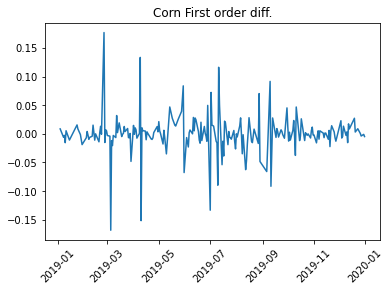

In [4]:
plt.plot(CORN.Date, CORN.CORN.diff(periods=1))
plt.title("Corn First order diff.")
plt.xticks(rotation=45)

plt.show()

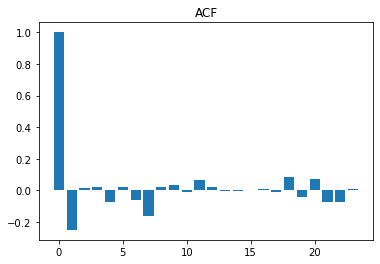

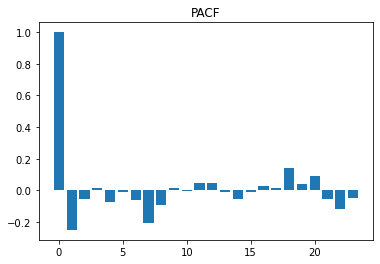

In [5]:
# ACF and PACF
order = 1
acf_list = acf(CORN.CORN.diff(periods=order).iloc[order:])
plt.bar(np.arange(0,len(acf_list), 1), acf_list)
plt.title("ACF"); plt.show()

pacf_list = pacf(CORN.CORN.diff(periods=order).iloc[order:])
plt.bar(np.arange(0,len(pacf_list), 1), pacf_list)
plt.title("PACF"); plt.show()

### ARIMA (p,d,q): Maybe ARIMA(1,1,0)... maybe ARIMA(0,1,1)... if I squint then both the PACF and ACF show a cutoff off after lag 1
### Best guess is ARIMA(0,1,1), because the cutoff after lag 1 is most evident in the ACF. 

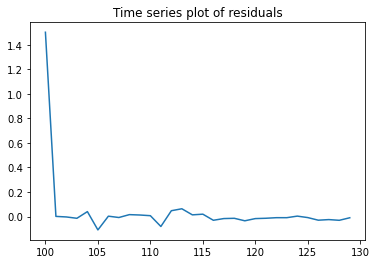

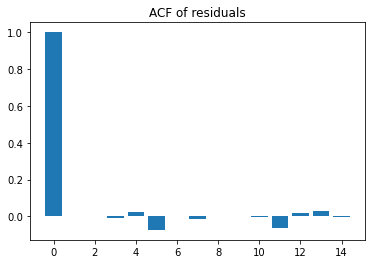

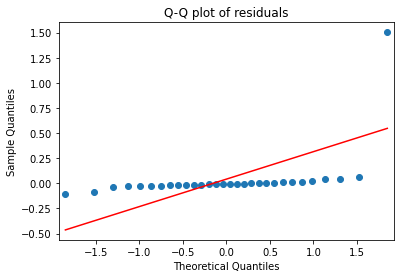

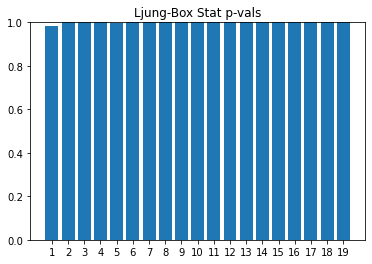

In [62]:
i = 100

training_days = 30

training_df = CORN.iloc[i:i+training_days]
test_df = CORN.iloc[i+training_days]

model = ARIMA(training_df.CORN, order=(2,1,2))
results = model.fit()    

    

plt.plot(results.resid)
plt.title("Time series plot of residuals")
plt.show()

acf_list = acf(results.resid)
plt.bar(np.arange(0,len(acf_list), 1), acf_list)
plt.title("ACF of residuals"); plt.show()
plt.show()


fig = qqplot(results.resid, line  = 's')
plt.title("Q-Q plot of residuals")
plt.show()

LB_stat, LB_stat_p_val = acorr_ljungbox(results.resid, lags=np.arange(1,20,1), return_df = False)
#print("Ljung-Box Statistic: " + str(LB_stat))
#print("Ljung-Box Statistic p-val: " + str(LB_stat_p_val))
plt.bar(np.arange(1,20,1), LB_stat_p_val)
plt.xticks(ticks = np.arange(1,20,1))
plt.ylim([0,1])
plt.title("Ljung-Box Stat p-vals")
plt.show()

## One day ahead forecasting 

In [63]:
# Rolling window

training_days = 30

true_values = []
predicted_values = []
dates = []
for i in range(int(CORN.shape[0] - training_days)):
    training_df = CORN.iloc[i:i+training_days]
    test_df = CORN.iloc[i+training_days]
    
    #print(training_df.CORN)
    #Test with ARMA(1,1)
    model = ARIMA(training_df.CORN, order=(2,1,0))
    results = model.fit()
    one_step_ahead_forecast = results.get_forecast(1).summary_frame().iloc[0,0]
    
    true_values.append(test_df.CORN)
    predicted_values.append(one_step_ahead_forecast)
    dates.append(test_df.Date)
    

/Users/matthewjohnson/opt/anaconda3/envs/stats207/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/matthewjohnson/opt/anaconda3/envs/stats207/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/matthewjohnson/opt/anaconda3/envs/stats207/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/matthewjohnson/opt/anaconda3/envs/stats207/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

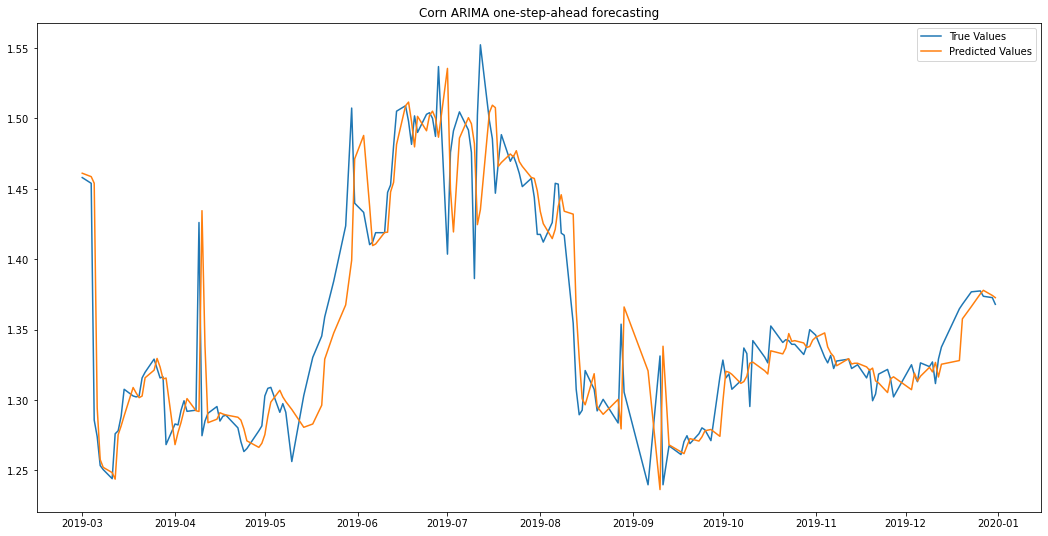

In [64]:
plt.figure(figsize=(18,9))
plt.plot(dates, true_values, dates, predicted_values)
plt.legend(["True Values", "Predicted Values"])
plt.title("Corn ARIMA one-step-ahead forecasting")
plt.show()

2.0562271360184647


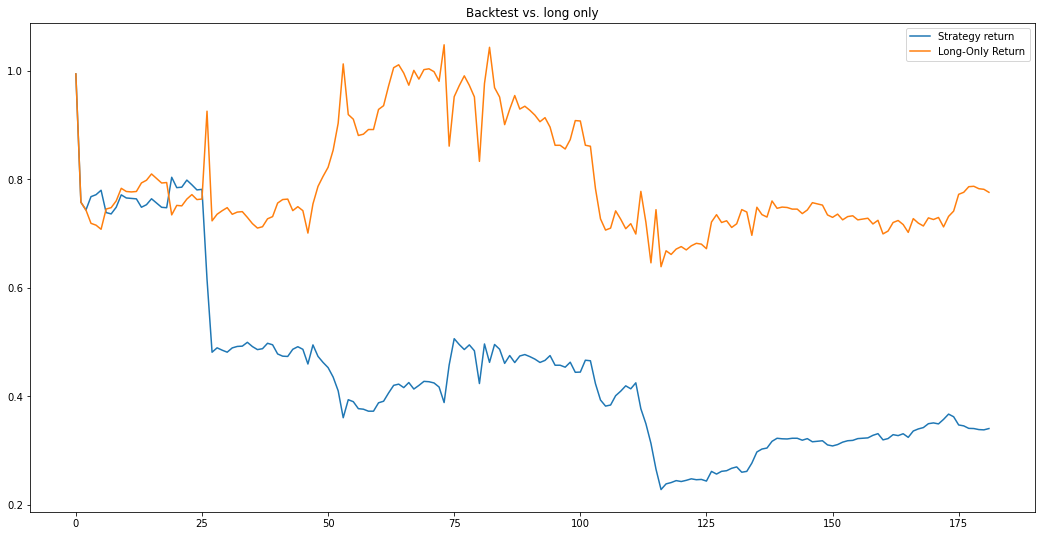

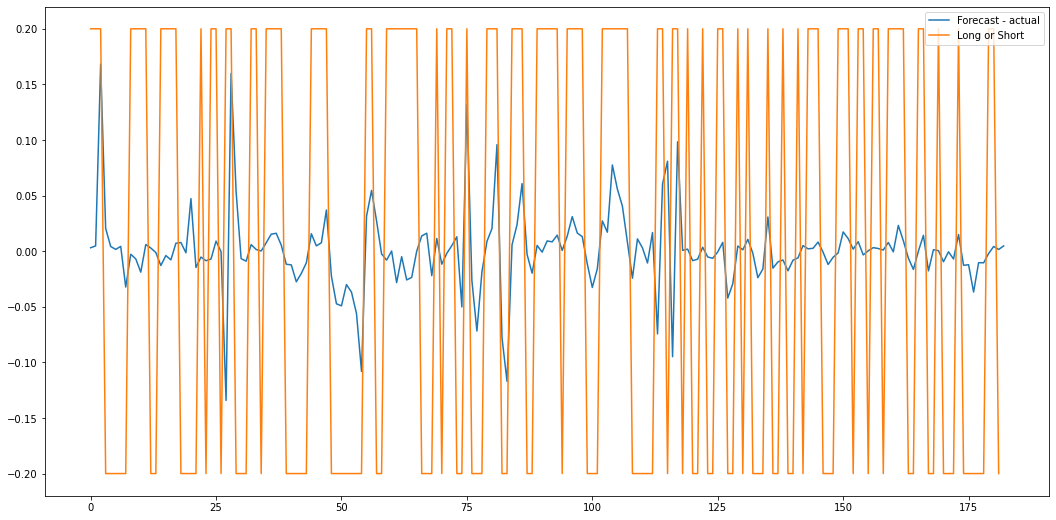

In [65]:
backtest(forecast_for_each_day=predicted_values, price_series=true_values)

### Errr... probably look-ahead/spilover in there somewhere

### Can confirm that the long-only plot is correct.